In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from neuron import PyramidalCells

lr = 5e-1
t_epoch = 0.5
dt = 0.001
tn = 50
n_cells = {'pyramidal' : 200, 'inter_a' : 10, 'inter_b' : 10, 'CA3' : 120}
n_epochs = 50
top_down = True
p_active = (1,1)

pyr = PyramidalCells(n_cells, dict(), lr, dt, p_active)
print(pyr.W_CA3.sum(axis=0).sum())

W = pyr.W_CA3.copy()


/scratch/fstella/felix/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/matplotlibrc
0.9999999999999998


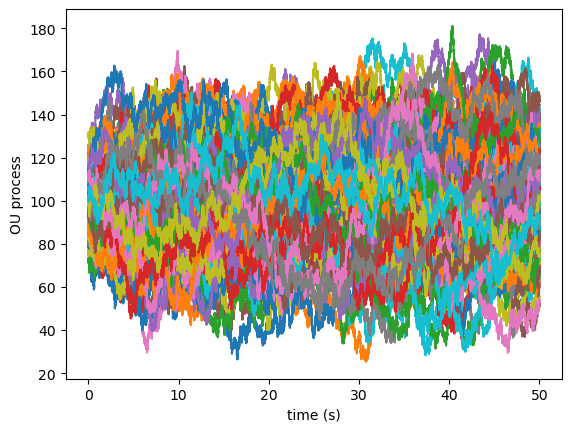

In [2]:
## create Ornstein Uhlenbeck process to drive neuron with noise 

def OU_process(tn, dt, tau, sigma, mu, n):
    n_t = int(tn/dt) + 1 
    x = np.zeros((n, n_t))
    x[:,0] = np.random.normal(mu,sigma,n)
    for i in range(1,n_t):
        dW = np.sqrt(dt) * np.random.normal(0, 1, n)
        x[:, i] = x[:, i-1] + dt*(mu-x[:, i-1])/tau + sigma*dW
    return x

# simulate process for tn seconds

input_basal = OU_process(tn, dt, 10, 20, 4000, n_cells['CA3'])
input_apical = OU_process(tn, dt, 10, 10, 100, n_cells['pyramidal'])

# plot process
plt.figure()
plt.plot(np.arange(0,tn + 1*dt,dt),input_apical.T)
plt.xlabel('time (s)')
plt.ylabel('OU process')
plt.show()

In [3]:
tn/dt

50000.0

In [ ]:
pyr.I_b = lambda t: input_basal[:,int(t/dt)]
pyr.I_a = lambda t: input_apical[:,int(t/dt)]

all_spikes = np.zeros((int(tn/dt), n_cells['pyramidal']))
all_bursts = np.zeros((int(tn/dt), n_cells['pyramidal']))
print(pyr.W_pi_a)

for i in range(n_epochs):
    t_epoch = tn//n_epochs
    
    pyr.I_b = lambda t: input_basal[:,int(t/dt + i*t_epoch/dt)]
    pyr.I_a = lambda t: input_apical[:,int(t/dt + i*t_epoch/dt)]

    pyr.W_CA3 = W.copy()  # Reset pyr.W_CA3 to the original value stored in W
    pyr.run_one_epoch(t_epoch, plasticity = True)
    print(pyr.W_CA3)

    all_spikes[int(i*t_epoch/dt):int((i+1)*t_epoch/dt),:] = pyr.spike_count
    all_bursts[int(i*t_epoch/dt):int((i+1)*t_epoch/dt),:] = pyr.burst_count

[[7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]
 ...
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]]


Plasticity step: 1
[[8.32378005e-05 5.64237357e-05 1.93401781e-07 ... 1.84150658e-05
  1.50173625e-05 8.67642622e-06]
 [2.63364339e-05 7.34917410e-05 4.39081541e-05 ... 1.15135725e-05
  3.19810033e-05 8.10148394e-05]
 [6.80212460e-07 3.98886132e-05 6.17201406e-05 ... 7.84334769e-06
  2.30747527e-05 7.75124712e-05]
 ...
 [2.08009779e-05 5.92026897e-05 4.27920818e-05 ... 1.09855933e-05
  6.05619723e-05 4.07749685e-05]
 [5.41944205e-06 3.52625991e-05 2.52350637e-05 ... 4.85544690e-05
  4.16295430e-05 8.26363028e-05]
 [2.32095652e-06 4.70731248e-05 7.27622548e-05 ... 4.18705187e-05
  6.32079654e-05 7.74252839e-05]]
Plasticity step: 2
[[0.12524149 0.1248043  0.12663574 ... 0.12668297 0.12573278 0.12516343]
 [0.13561444 0.13521702 0.13723242 ... 0.13723145 0.13622623 0.13566533]
 [0.12515893 0.12478776 0.12669727 ... 0.1266724  0.12574084 0.12523226]
 ...
 [0.1356089  0.13520274 0.1372313  ... 0.13723092 0.13625481 0.13562509]
 [0.12516367 0.12478314 0.12666078 ... 0.12671311 0.1257594  0.12

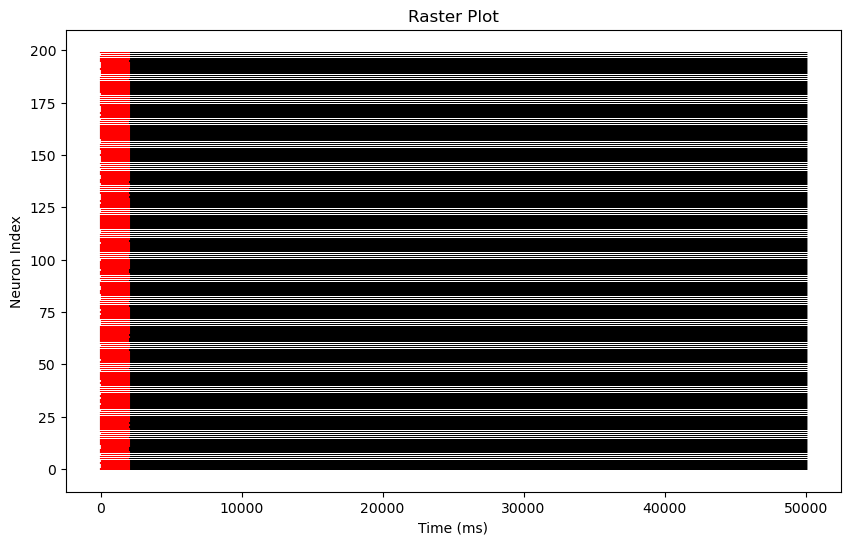

781
15
(200, 64)


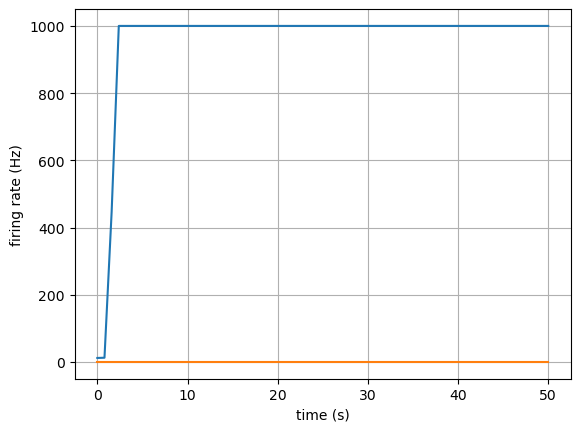

In [5]:
pyr.spike_count.shape

spike_times = [np.where(all_spikes[:, i] == 1)[0] for i in range(pyr.spike_count.shape[1])]
burst_times = [np.where(all_bursts[:, i] == 1)[0] for i in range(pyr.burst_count.shape[1])]

# Create the raster plot
plt.figure(figsize=(10, 6))
plt.eventplot(spike_times, linelengths=0.8, color="black")
plt.eventplot(burst_times, linelengths=0.8, color="red")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron Index")
plt.title("Raster Plot")
plt.show()



def get_firing_rates(pyramidal, event_count):

    firing_rates = np.zeros((event_count.shape[1], 64))
    step_size = len(event_count)//firing_rates.shape[1]
    print(step_size)
    
    for i in range(firing_rates.shape[1]):
        firing_rates[:, i] = np.sum(event_count[i * step_size:(i + 1) * step_size, :], axis = 0) / (step_size*pyramidal.dt)

    return firing_rates

spike_rate = get_firing_rates(pyr, all_spikes)
burst_rate = get_firing_rates(pyr, pyr.burst_count)

print(spike_rate.shape)

t_sr = np.linspace(0, tn, spike_rate.shape[1])

plt.figure()
plt.plot(t_sr, np.mean(spike_rate, axis = 0))
plt.plot(t_sr, np.mean(burst_rate, axis = 0))
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
# plt.ylim(-1, 30)
plt.grid()
plt.show()

In [6]:
W = np.ones((3,4))
lr = 0.1

trace_pre = np.array([1, 0, 1, 0.5])
spike_pre = np.array([0, 1, 0, 0])

trace_post = np.array([0, 0, 1])
spike_post = np.array([0, 1, 1])

alpha = 10

print(W)
np.where([[True, False], [True, True]],
         [[1, 2], [3, 4]],
         [[9, 8], [7, 6]])
W = np.where(spike_pre , W + lr * (trace_post - alpha)[:, np.newaxis], W)  ### for presynaptic spikes 
print(W)
W = np.where(spike_post[:, np.newaxis] , W + lr * trace_pre[np.newaxis, :], W)
print(W)


[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[1.  0.  1.  1. ]
 [1.  0.  1.  1. ]
 [1.  0.1 1.  1. ]]
[[1.   0.   1.   1.  ]
 [1.1  0.   1.1  1.05]
 [1.1  0.1  1.1  1.05]]
